# Exploring the Files and Analyzing Folder Structures (Supported Files)

## Repeat previous analysis for Glasswall Supported Files

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

**Important:** Set the path to the folder you are going to analyze

In [3]:
import ipywidgets as widgets
import ipython_blocking

path_input = widgets.Text(
    placeholder='/home/jovyan/test_data',
    description='Folder Path',
    disabled=False,
    value='/home/jovyan/test_data',
    )

button = widgets.Button(description='Run')

box = widgets.VBox(children=[path_input, button])
display(box)

<IPython.core.display.Javascript object>

In [6]:
%blockrun button

Let's get a Pandas dataframe with all files information needed for the visualizations

In [7]:
import folderstats

folder = path_input.value
df = folderstats.folderstats(folder, ignore_hidden=True)

# Supported files list:
supported_files = ['pdf', 'PDF', 'jpg', 'JPG', 'gif', 'GIF', 'png', 'PNG', 'emf', 'EMF', 'wmf', 'WMF', 'tiff', 'TIFF', 'GeoTIFF', 'geotiff', 'bmp', 'BMP',
                   'doc', 'DOC', 'dot', 'DOT', 'xls', 'XLS', 'xlt', 'XLT', 'ppt', 'PPT', 'pot', 'POT', 'docx', 'DOCX', 'docm', 'DOCM', 'dotx', 'DOTX',
                   'dotm', 'DOTM', 'xlsx', 'XLSX', 'xlam', 'XLAM', 'xlsm', 'XLSM', 'xltx', 'XLTX', 'xltm', 'XLTM', 'xpptx', 'XPPTX', 'potx', 'POTX', 
                   'potm', 'POTM', 'pptm', 'PPTM', 'ppsx', 'PPSX', 'ppam', 'PPAM', 'ppsm', 'PPSM', 'wab', 'WAB', 'mp3', 'MP3', 'mpg', 'MPG', 'mp4', 'MP4',
                   'pe', 'PE', 'dll', 'DLL', 'mui', 'MUI', 'exe', 'EXE', 'mach-o', 'MACH-O', 'coff', 'COFF', 'elf', 'ELF']

df_supported = df[df['extension'].isin(supported_files)]
df_not_supported = df[~df['extension'].isin(supported_files)]

df = df_supported

## Treemap

The following treemap shows the size of each file extension.

This already gives some interesting insight into the way the files are distributed in the folder. Exploring your file system by size can be very helpful when looking for files or folders that you don’t need, but eat up a lot of memory.

In [8]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import squarify

# Group by extension and sum all sizes for each extension
extension_sizes = df.groupby('extension')['size'].sum()
# Sort elements by size
extension_sizes = extension_sizes.sort_values(ascending=False)

m = len(extension_sizes)
if m >= 20:
    if m <= 30: p = 0.7
    elif m <= 40: p = 0.6
    elif m <= 60: p = 0.4
    else: p = 0.35
else:
    p = 1

w = widgets.IntSlider(
        value= p*len(extension_sizes),
        min=1,
        max=len(extension_sizes),
        step=1,
        description='Extensions',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

@interact
def treemap(w = w):

    plt.rcParams.update({'font.size': 22}) 

    plt.figure(figsize=(25,15))

    squarify.plot(sizes=extension_sizes[:w].values, label=extension_sizes[:w].index.values)
    plt.title('Extension Treemap by Size')
    plt.axis('off');

interactive(children=(IntSlider(value=7, continuous_update=False, description='Extensions', max=7, min=1), Out…

According to Zipf's law (a discrete form of the continuous Pareto distribution), the second largest file type will be about half the size of the largest. The third largest, one third the size of the largest. The fourth, one fourth, and so on. 

## Graphs

The folder structure can be represented with a graph using NetworkX package. 

In [9]:
import networkx as nx

# Sort the index
df_sorted = df.sort_values(by='id')

G = nx.Graph()
# To build the graph we iterate over the dataframe and create an edge from row.id to row.parent
for i, row in df_sorted.iterrows():
    if row.parent:
        G.add_edge(row.id, row.parent)
    
# Print some additional information
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 456
Number of edges: 406
Average degree:   1.7807


The total number of nodes is how many files and folders we have. The total number of edges is equal to the total number of nodes minus one, since every file and folder can be in only one folder and the first folder has no parent folder, this makes sense. The average degree is the average number of edges that a node can have.

Now we could apply all sorts of available [Algorithms](https://networkx.org/documentation/networkx-1.10/reference/algorithms.html) and [Functions](https://networkx.org/documentation/networkx-1.10/reference/functions.html) that can be applied to explore and analyze the folder structure.

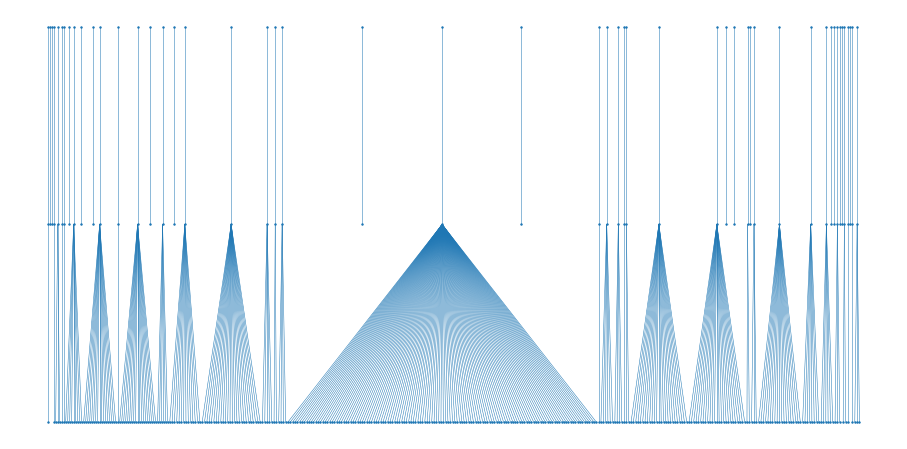

In [10]:
from networkx.drawing.nx_pydot import graphviz_layout

pos_dot = graphviz_layout(G, prog='dot')

fig = plt.figure(figsize=(16, 8))
nodes = nx.draw_networkx_nodes(G, pos_dot, node_size=2, node_color='C0')
edges = nx.draw_networkx_edges(G, pos_dot, edge_color='C0', width=0.5)
plt.axis('off');

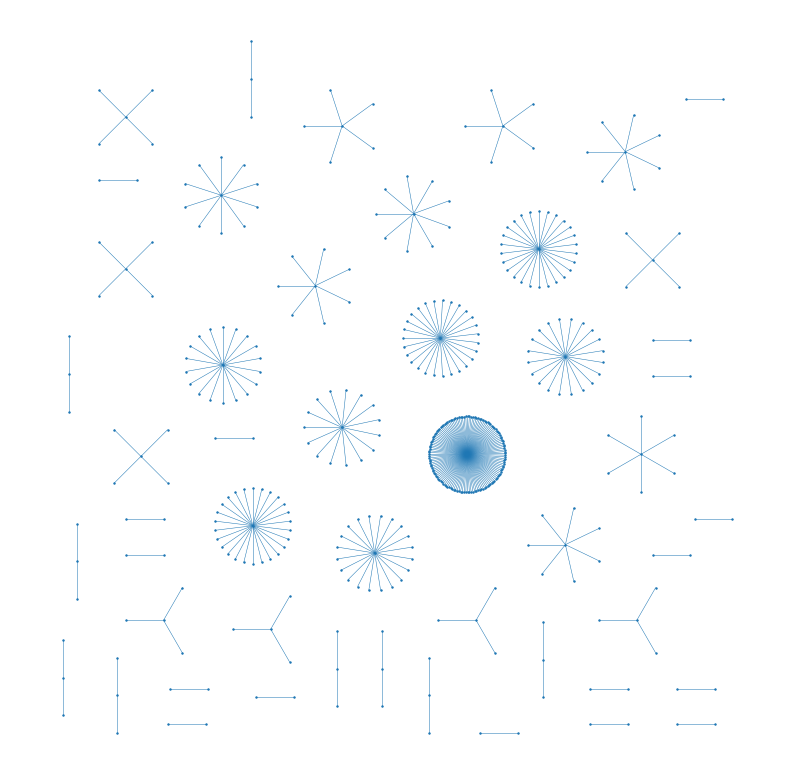

In [11]:
# using a radial layout

pos_twopi = graphviz_layout(G, prog='twopi', root=1)

fig = plt.figure(figsize=(14, 14))
nodes = nx.draw_networkx_nodes(G, pos_twopi, node_size=2, node_color='C0')
edges = nx.draw_networkx_edges(G, pos_twopi, edge_color='C0', width=0.5)
plt.axis('off')
plt.axis('equal');

Be aware though, that the time to compute these graph drawing can get quickly out of hand for large graphs (>10000)

## Table

It is very helpful to display the dataframe on a qgrid so we can filter it

In [12]:
import qgrid

qgrid_widget = qgrid.show_grid(df, show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [13]:
# If you filter the data, can get the new df with the following command
# qgrid_widget.get_changed_df()

### Some references

**size** describes the number of bytes by the file. (Note: Folders also have a size, although the size is excluding the files inside). The **folder** flag specifies whether this element is a folder, the **num_files** is the number of files within the folder, and the **depth** states how many layers of folders the file or folder is. Finally, **id** and **parent** are responsible to see the links between files and folders which can be used to create a graph.

##### Timestamps:

* **atime**: time of last access
* **mtime**: time of last modification
* **ctime**: time of last status (metadata) change like file permissions, file ownership, etc. (creation time in Windows)

Find more about what each field means on https://en.wikipedia.org/wiki/Stat_(system_call)

## Bar Charts

### Counting different types of file extensions

Let's explore the distribution of files by their file extensions.

In the first visualization, you will see the distribution sorted by their occurrence.

In [14]:
w = widgets.IntSlider(
        value=len(df['extension'].value_counts()),
        min=1,
        max=len(df['extension'].value_counts()),
        step=1,
        description='Extensions',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

@interact
def bar_chart(w = w):
    
    plt.figure(figsize=(20,10))

    with plt.style.context('ggplot'):
        df['extension'].value_counts()[:w].plot(kind='bar', color='C1', title='Extension Distribution by Count');

interactive(children=(IntSlider(value=7, continuous_update=False, description='Extensions', max=7, min=1), Out…

### File extension by size

This showed us only the counts, but what about the sizes?

In [15]:
# To do this you can use the Pandas .groupby() method to group all extensions. 
# After grouping the files by file extension you can sum all of their sizes

# Group by extension and sum all sizes for each extension 
extension_sizes = df.groupby('extension')['size'].sum()
# Sort elements by size
extension_sizes = extension_sizes.sort_values(ascending=False)

w = widgets.IntSlider(
        value=len(extension_sizes),
        min=1,
        max=len(extension_sizes),
        step=1,
        description='Extensions',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

@interact
def bar_chart(w = w):

    with plt.style.context('ggplot'):
    
        extension_sizes = df.groupby('extension')['size'].sum()
        extension_sizes = extension_sizes.sort_values(ascending=False)
        extension_sizes = extension_sizes[:w]
        
        plt.figure(figsize=(20,10))
        
        extension_sizes.plot(kind='bar', color='C1', title='Extension Distribution by Size');

interactive(children=(IntSlider(value=7, continuous_update=False, description='Extensions', max=7, min=1), Out…

### Folder sizes

Next, we can have a look now at the largest folders in the repository. The first thing to do, is to filter the data set to only have folders. The rest should be familiar to the previous visualizations

In [16]:
# Filter the data set to only folders
df_folders = df[df['folder']]
# Set the name to be the index (so we can use it as a label later)
df_folders.set_index('name', inplace=True)
# Sort the folders by size
df_folders = df_folders.sort_values(by='size', ascending=False)

w = widgets.IntSlider(
        value=len(df_folders)//5,
        min=1,
        max=len(df_folders),
        step=1,
        description='Num Folders',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

@interact
def bar_chart(w = w):
    
    if len(df_folders) != 0:

        with plt.style.context('ggplot'):
        
            plt.figure(figsize=(20,10))
            df_folders['size'][:w].plot(kind='bar', color='C0', title='Folder Sizes');

TraitError: setting min > max

Reference: https://janakiev.com/blog/python-filesystem-analysis/